<a href="https://colab.research.google.com/github/Ayaan577/SentimentStockPredictor/blob/main/StockPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# ====================
#      Imports
# ====================

import os
import csv
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
from math import sqrt
from tqdm import tqdm
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

# Scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Pickle for saving scalers
from pickle import dump, load

# NLTK for sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
nltk.download('vader_lexicon')


In [6]:
# Set stock symbol
stock_name = 'AMZN'

In [7]:
# ====================
#  Data Loading & Filtering
# ====================
def load_data(tweets_path, stocks_path, stock_symbol):
    # Load tweets
    all_tweets = pd.read_csv(tweets_path)
    print("All Tweets Shape:", all_tweets.shape)

    # Filter tweets for the specified stock
    df = all_tweets[all_tweets['Stock Name'] == stock_symbol]
    print("Filtered Tweets Shape:", df.shape)

    # Load stock data
    all_stocks = pd.read_csv(stocks_path)
    print("Stock Data Shape:", all_stocks.shape)

    stock_df = all_stocks[all_stocks['Stock Name'] == stock_symbol]
    stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
    return df, stock_df

# Update file paths as needed
tweets_file_path = "/content/drive/MyDrive/stock/stock_tweets.csv"
stocks_file_path = "/content/drive/MyDrive/stock/stock_yfinance_data.csv"

df_tweets, stock_df = load_data(tweets_file_path, stocks_file_path, stock_name)


All Tweets Shape: (80793, 4)
Filtered Tweets Shape: (4089, 4)
Stock Data Shape: (6300, 8)


In [8]:
# ====================
#  Sentiment Analysis
# ====================
def perform_sentiment_analysis(df):
    # Create a copy and initialize sentiment columns
    sent_df = df.copy()
    sent_df["sentiment_score"] = ''
    sent_df["Negative"] = ''
    sent_df["Neutral"] = ''
    sent_df["Positive"] = ''

    # Initialize VADER sentiment analyzer
    sentiment_analyzer = SentimentIntensityAnalyzer()

    # Process each tweet and compute sentiment scores
    for indx, row in sent_df.iterrows():
        try:
            tweet_text = unicodedata.normalize('NFKD', sent_df.loc[indx, 'Tweet'])
            scores = sentiment_analyzer.polarity_scores(tweet_text)
            sent_df.at[indx, 'sentiment_score'] = scores['compound']
            sent_df.at[indx, 'Negative'] = scores['neg']
            sent_df.at[indx, 'Neutral'] = scores['neu']
            sent_df.at[indx, 'Positive'] = scores['pos']
        except TypeError:
            print("Error processing tweet at index:", indx)
            break
    return sent_df

sent_df = perform_sentiment_analysis(df_tweets)
print(sent_df.head())

# Convert Date column and drop unnecessary columns
sent_df['Date'] = pd.to_datetime(sent_df['Date']).dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])
# Group by Date to get daily average sentiment score
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
twitter_df = sent_df.groupby('Date', as_index=False)['sentiment_score'].mean()
print("Grouped Twitter Data Shape:", twitter_df.shape)
print(twitter_df.head())


                            Date  \
48351  2022-09-29 22:40:47+00:00   
48352  2022-09-29 22:23:54+00:00   
48353  2022-09-29 18:34:51+00:00   
48354  2022-09-29 15:57:59+00:00   
48355  2022-09-29 15:10:30+00:00   

                                                   Tweet Stock Name  \
48351  A group of lawmakers led by Sen. Elizabeth War...       AMZN   
48352  $NIO just because I'm down money doesn't mean ...       AMZN   
48353  Today’s drop in $SPX is a perfect example of w...       AMZN   
48354  Druckenmiller owned $CVNA this year \nMunger b...       AMZN   
48355  Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...       AMZN   

           Company Name sentiment_score Negative Neutral Positive  
48351  Amazon.com, Inc.         -0.0772    0.084   0.841    0.075  
48352  Amazon.com, Inc.            0.25    0.158   0.684    0.158  
48353  Amazon.com, Inc.         -0.3182    0.164   0.728    0.108  
48354  Amazon.com, Inc.          0.2382    0.065   0.851    0.083  
48355  Amazon.co

Final Merged Data Shape: (252, 8)
        Date        Open        High         Low       Close   Adj Close  \
0 2021-09-30  165.800003  166.392502  163.699493  164.251999  164.251999   
1 2021-10-01  164.450500  165.458496  162.796997  164.162994  164.162994   
2 2021-10-04  163.969498  163.999496  158.812500  159.488998  159.488998   
3 2021-10-05  160.225006  163.036499  160.123001  161.050003  161.050003   
4 2021-10-06  160.676498  163.216995  159.931000  163.100494  163.100494   

     Volume sentiment_score  
0  56848000         0.24648  
1  56712000        0.359338  
2  90462000         0.25865  
3  65384000          0.0455  
4  50660000          0.1943  


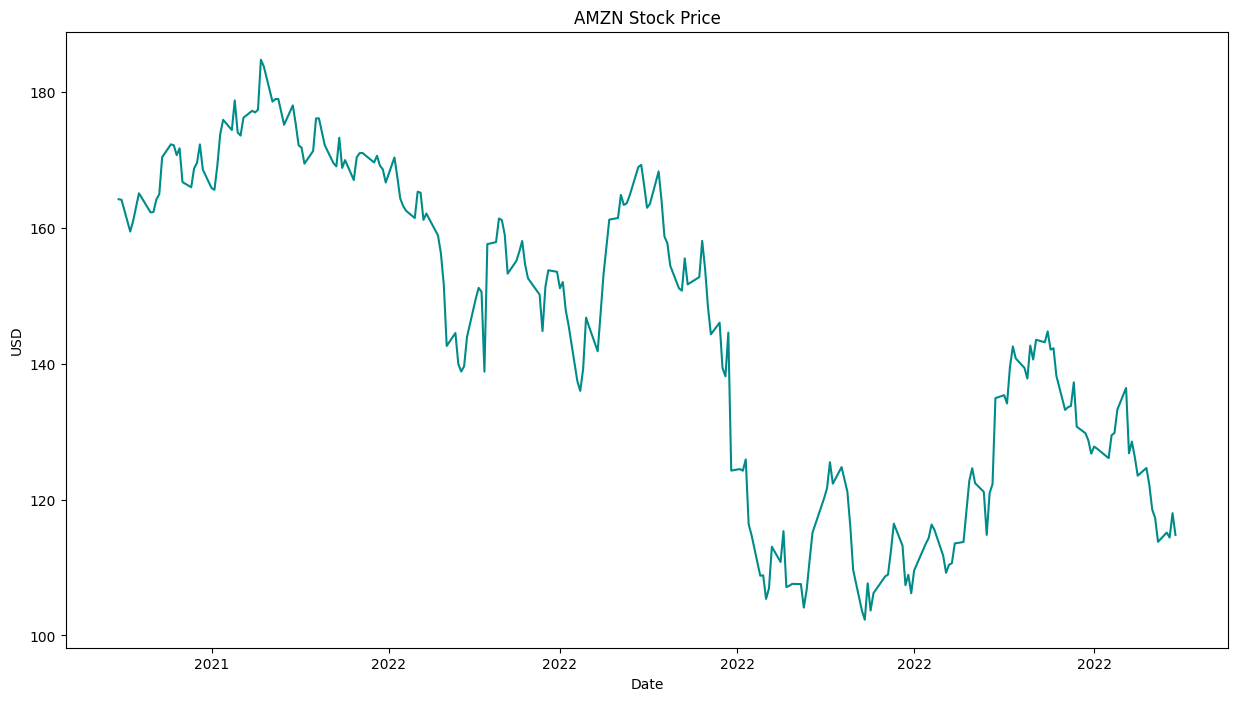

        Date        Open        High         Low       Close   Adj Close  \
0 2021-10-28  170.104996  173.949997  169.300003  172.328506  172.328506   
1 2021-10-29  165.001007  168.740997  163.666000  168.621506  168.621506   
2 2021-11-01  168.089996  168.792999  164.600998  165.905502  165.905502   
3 2021-11-02  165.750504  166.556000  164.177505  165.637497  165.637497   
4 2021-11-03  165.449997  169.746002  164.876007  169.199997  169.199997   

      Volume sentiment_score         MA7        MA20      MACD      20SD  \
0  114174000        -0.00145  169.436571  166.614751 -1.073771  4.111286   
1  129722000        0.140447  169.132071  166.837676 -0.959835  4.092180   
2   72178000        0.373936  168.297071  167.158501 -0.675574  3.720357   
3   52552000        0.336614  168.134214  167.387876 -0.428396  3.455945   
4   67944000        0.260729  168.588715  167.692851 -0.478758  3.324309   

   upper_band  lower_band         EMA  logmomentum  
0  174.837323  158.392179  171.26

In [9]:
# ====================
#  Merge Data & Technical Indicators
# ====================
def merge_data(stock_df, twitter_df):
    # Ensure Date columns are in datetime format
    stock_df["Date"] = pd.to_datetime(stock_df["Date"])
    twitter_df["Date"] = pd.to_datetime(twitter_df["Date"])
    # Merge on Date
    final_df = stock_df.merge(twitter_df, on="Date", how="left")
    if "Stock Name" in final_df.columns:
        final_df = final_df.drop(columns=["Stock Name"])
    return final_df

final_df = merge_data(stock_df, twitter_df)
print("Final Merged Data Shape:", final_df.shape)
print(final_df.head())

# Plot stock price
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

def get_tech_indicators(data):
    # Compute Moving Averages
    data['MA7'] = data['Close'].rolling(window=7).mean()
    data['MA20'] = data['Close'].rolling(window=20).mean()
    # Compute MACD
    data['MACD'] = data['Close'].ewm(span=26).mean() - data['Close'].ewm(span=12).mean()
    # Bollinger Bands
    data['20SD'] = data['Close'].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)
    # Exponential Moving Average and Log Momentum
    data['EMA'] = data['Close'].ewm(com=0.5).mean()
    data['logmomentum'] = np.log(data['Close'] - 1)
    return data

tech_df = get_tech_indicators(final_df)
dataset = tech_df.iloc[20:, :].reset_index(drop=True)
print(dataset.head())

# Optionally save dataset
dataset.to_csv("dataset.csv", index=False)
print("Dataset saved to dataset.csv")

# Forward-fill missing values (if any)
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])
# Set Date index for time-series analysis
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2610
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1056
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0236
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0448
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0277
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0135
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0178
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0158
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0117
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0134
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0126
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0116
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0112
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0109
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0111
Epoch 16/100
4/4 ━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


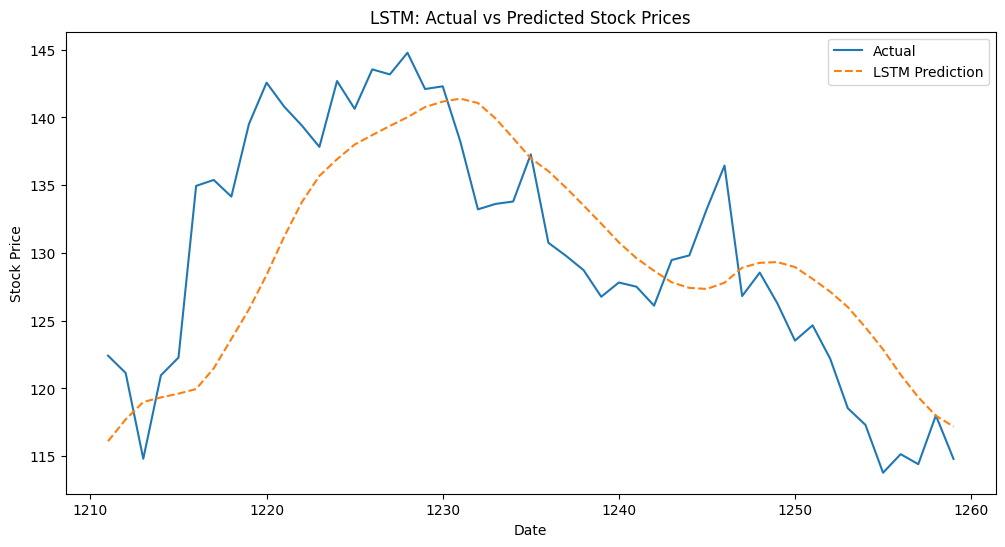

LSTM Performance Metrics:
MAE: 5.16
MSE: 39.60
RMSE: 6.29
R²: 0.5200


In [10]:
# ====================
#  LSTM Model for Stock Prediction
# ====================
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Normalize closing price using only the 'Close' column from stock_df
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(stock_df[['Close']])  # Use stock_df or final_df depending on context
seq_length = 10
X_seq, y_seq = create_sequences(scaled_close, seq_length)

# Train-Test Split
split = int(len(X_seq) * 0.8)
X_train, y_train = X_seq[:split], y_seq[:split]
X_test, y_test = X_seq[split:], y_seq[split:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=100, batch_size=64)

# Make predictions with LSTM
predictions = lstm_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Use the correct dataset (stock_df or final_df)
plt.figure(figsize=(12, 6))
plt.plot(stock_df.index[-len(predictions):], stock_df['Close'].values[-len(predictions):], label="Actual")
plt.plot(stock_df.index[-len(predictions):], predictions, label="LSTM Prediction", linestyle="dashed")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("LSTM: Actual vs Predicted Stock Prices")
plt.show()


# Evaluate LSTM predictions
y_test_actual = scaler.inverse_transform(y_test)
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)
print(f"LSTM Performance Metrics:\nMAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}")

Batched shapes: X: (227, 5, 15) y: (227, 1) yc: (227, 5, 1)


 10%|█         | 50/500 [02:16<18:25,  2.46s/it]

Epoch 50, D Loss: 1.3756091594696045, G Loss: 0.6880186796188354


 20%|██        | 100/500 [04:00<16:28,  2.47s/it]

Epoch 100, D Loss: 1.3909236192703247, G Loss: 0.6889919638633728


 30%|███       | 150/500 [05:41<12:49,  2.20s/it]

Epoch 150, D Loss: 1.3805372714996338, G Loss: 0.6929708123207092


 40%|████      | 200/500 [07:24<11:07,  2.22s/it]

Epoch 200, D Loss: 1.374080777168274, G Loss: 0.6950095295906067


 50%|█████     | 250/500 [09:05<07:51,  1.89s/it]

Epoch 250, D Loss: 1.384725570678711, G Loss: 0.698779284954071


 60%|██████    | 300/500 [10:46<06:34,  1.97s/it]

Epoch 300, D Loss: 1.3882732391357422, G Loss: 0.6900675892829895


 70%|███████   | 350/500 [12:29<04:58,  1.99s/it]

Epoch 350, D Loss: 1.3881607055664062, G Loss: 0.6864688992500305


 80%|████████  | 400/500 [14:09<03:44,  2.24s/it]

Epoch 400, D Loss: 1.3877456188201904, G Loss: 0.7129431366920471


 90%|█████████ | 450/500 [15:50<01:49,  2.19s/it]

Epoch 450, D Loss: 1.3908476829528809, G Loss: 0.6893824934959412


100%|██████████| 500/500 [17:31<00:00,  2.10s/it]


Epoch 500, D Loss: 1.387293815612793, G Loss: 0.6930862665176392


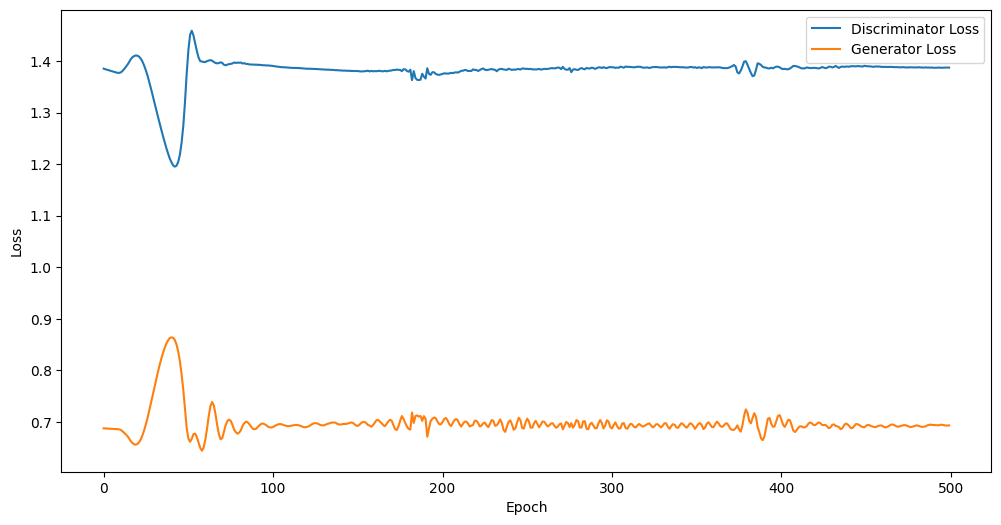

GAN model weights saved.


In [11]:
# ====================
#  GAN Components
# ====================
def make_generator_model(input_dim, output_dim, feature_size):
    model = Sequential([
        LSTM(1024, return_sequences=True, input_shape=(input_dim, feature_size), recurrent_dropout=0.3),
        LSTM(512, return_sequences=True, recurrent_dropout=0.3),
        LSTM(256, return_sequences=True, recurrent_dropout=0.3),
        LSTM(128, return_sequences=True, recurrent_dropout=0.3),
        LSTM(64, recurrent_dropout=0.3),
        Dense(32),
        Dense(16),
        Dense(8),
        Dense(output_dim)
    ])
    return model

def make_discriminator_model(input_dim):
    model = Sequential([
        Conv1D(8, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01), input_shape=(input_dim+1, 1)),
        Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
        Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
        Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
        Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)),
        LeakyReLU(),
        Dense(220, use_bias=False),
        LeakyReLU(),
        Dense(220, use_bias=False, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def discriminator_loss(real_output, fake_output):
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_fn(tf.ones_like(real_output), real_output)
    fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return loss_fn(tf.ones_like(fake_output), fake_output)

@tf.function
def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return real_y, generated_data, {'d_loss': d_loss, 'g_loss': g_loss}

def train_gan(real_x, real_y, yc, epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint=50):
    train_info = {"discriminator_loss": [], "generator_loss": []}
    for epoch in tqdm(range(epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        train_info["discriminator_loss"].append(loss['d_loss'].numpy())
        train_info["generator_loss"].append(loss['g_loss'].numpy())
        if (epoch + 1) % checkpoint == 0:
            generator.save(f'./models_gan/{stock_name}/generator_V_{epoch}.h5')
            discriminator.save(f'./models_gan/{stock_name}/discriminator_V_{epoch}.h5')
            print(f'Epoch {epoch+1}, D Loss: {loss["d_loss"].numpy()}, G Loss: {loss["g_loss"].numpy()}')
    # Plot training losses
    plt.figure(figsize=(12, 6))
    plt.plot(train_info["discriminator_loss"], label='Discriminator Loss')
    plt.plot(train_info["generator_loss"], label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return fake_price.numpy(), real_price.numpy()

# Prepare data for GAN training using helper functions (normalize, batch, split, etc.)
def normalize_data_func(df, feature_range, target_column):
    target_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df)
    X_scaler = MinMaxScaler(feature_range=feature_range)
    y_scaler = MinMaxScaler(feature_range=feature_range)
    X_scaler.fit(data)
    y_scaler.fit(target_series)
    X_scaled = X_scaler.transform(data)
    y_scaled = y_scaler.transform(target_series)
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))
    return X_scaled, y_scaled

def batch_data(x_data, y_data, batch_size, predict_period):
    X_batched, y_batched, yc = [], [], []
    for i in range(len(x_data)):
        x_val = x_data[i: i + batch_size]
        y_val = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_val = y_data[i: i + batch_size]
        if len(x_val) == batch_size and len(y_val) == predict_period:
            X_batched.append(x_val)
            y_batched.append(y_val)
            yc.append(yc_val)
    return np.array(X_batched), np.array(y_batched), np.array(yc)

def split_train_test_func(data):
    train_size = len(data) - 20
    return data[:train_size], data[train_size:]

def predict_index_func(dataset, X_train, batch_size, prediction_period):
    train_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index
    return train_index, test_index

# Use the dataset (created earlier from technical indicators) for GAN training
dataset_numeric = dataset.select_dtypes(include=['number'])
X_scaled, y_scaled = normalize_data_func(dataset_numeric, (-1,1), "Close")
X_scaled, y_scaled = normalize_data_func(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scaled, y_scaled, batch_size=5, predict_period=1)
print("Batched shapes: X:", X_batched.shape, "y:", y_batched.shape, "yc:", yc.shape)

X_train_gan, X_test_gan = split_train_test_func(X_batched)
y_train_gan, y_test_gan = split_train_test_func(y_batched)
yc_train, yc_test = split_train_test_func(yc)
index_train, index_test = predict_index_func(dataset, X_train_gan, 5, 1)

input_dim = X_train_gan.shape[1]
feature_size = X_train_gan.shape[2]
output_dim = y_train_gan.shape[1]

# Build GAN models
generator = make_generator_model(X_train_gan.shape[1], output_dim, X_train_gan.shape[2])
discriminator = make_discriminator_model(X_train_gan.shape[1])

# Set GAN training parameters and optimizers
g_optimizer = Adam(learning_rate=5e-4)
d_optimizer = Adam(learning_rate=5e-4)
epochs_gan = 500

# Optionally, plot model architectures
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

def train(real_x, real_y, yc, epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint=50):
    train_info = {"discriminator_loss": [], "generator_loss": []}
    for epoch in tqdm(range(epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        train_info["discriminator_loss"].append(loss['d_loss'].numpy())
        train_info["generator_loss"].append(loss['g_loss'].numpy())
        if (epoch + 1) % checkpoint == 0:
            generator.save(f'./models_gan/{stock_name}/generator_V_{epoch}.h5')
            discriminator.save(f'./models_gan/{stock_name}/discriminator_V_{epoch}.h5')
            print(f'Epoch {epoch+1}, D Loss: {loss["d_loss"].numpy()}, G Loss: {loss["g_loss"].numpy()}')
    # Plot training losses
    plt.figure(figsize=(12, 6))
    plt.plot(train_info["discriminator_loss"], label='Discriminator Loss')
    plt.plot(train_info["generator_loss"], label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return fake_price.numpy(), real_price.numpy()

# Train GAN
predicted_price, real_price = train(X_train_gan, y_train_gan, yc_train, epochs_gan, generator, discriminator, g_optimizer, d_optimizer)

# Recreate generator structure and load saved weights
generator = make_generator_model(X_train_gan.shape[1], output_dim, X_train_gan.shape[2])
generator.load_weights(f'./models_gan/{stock_name}/generator_V_{epochs_gan-1}.h5')
generator.save_weights("generator_weights.weights.h5")
discriminator.save_weights("discriminator_weights.weights.h5")
print("GAN model weights saved.")

# Evaluate GAN on test data (Assuming test_generator is defined if needed)
@tf.function
def eval_op(generator, real_x):
    return generator(real_x, training=False)

# (If a test_generator is defined; else, use generator on X_test_gan)
# predicted_test_data = eval_op(generator, X_test_gan)
# plot_test_data(y_test_gan, predicted_test_data, index_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 850ms/step
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2961
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1463
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0846
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0396
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0342
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0270
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0250
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0203
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0204
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0167
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0185
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0200
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0163
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0147
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

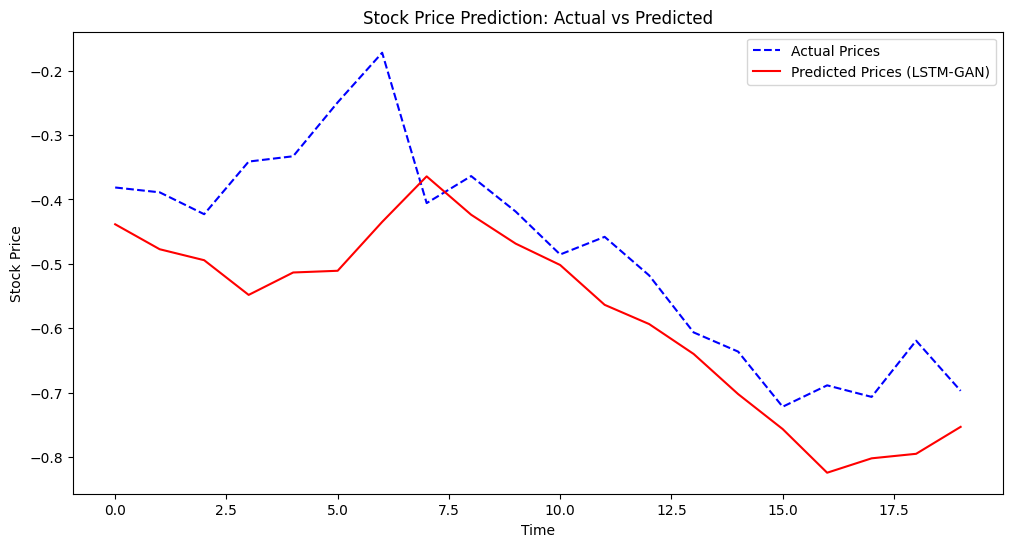

LSTM-GAN Performance Metrics:
✅ RMSE: 0.1269
✅ MAE: 0.1037
✅ MAPE: 29.83%
✅ R² Score: 0.3497


In [12]:
# ====================
#  LSTM with GAN Integration
# ====================
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        LSTM(64, return_sequences=False),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

def train_lstm_with_gan(generator, X_train, y_train, epochs=100):
    generated_features = generator.predict(X_train)
    # Reshape generated features to match X_train shape (repeat across timesteps)
    generated_features = np.expand_dims(generated_features, axis=1)
    generated_features = np.tile(generated_features, (1, X_train.shape[1], 1))
    combined_input = np.concatenate([X_train, generated_features], axis=-1)
    lstm_model = build_lstm_model(combined_input.shape[1:])
    lstm_model.fit(combined_input, y_train, epochs=epochs, batch_size=32, verbose=1)
    return lstm_model

def predict_with_lstm(lstm_model, generator, X_test):
    generated_features = generator.predict(X_test)
    print("Generated Features Shape (Before):", generated_features.shape)
    print("X_test Shape:", X_test.shape)
    generated_features = np.expand_dims(generated_features, axis=1)
    generated_features = np.tile(generated_features, (1, X_test.shape[1], 1))
    print("Generated Features Shape (After):", generated_features.shape)
    combined_input = np.concatenate([X_test, generated_features], axis=-1)
    print("Combined Input Shape:", combined_input.shape)
    return lstm_model.predict(combined_input)

# Train LSTM using GAN features
lstm_model_gan = train_lstm_with_gan(generator, X_train_gan, y_train_gan, epochs=100)
y_pred = predict_with_lstm(lstm_model_gan, generator, X_test_gan)

# Evaluate LSTM-GAN predictions
rmse_lstm_gan = np.sqrt(mean_squared_error(y_test_gan, y_pred))
print(f'LSTM-GAN RMSE: {rmse_lstm_gan}')

# Plot LSTM-GAN predictions vs actual
y_test_flat = np.array(y_test_gan).reshape(-1)
y_pred_flat = np.array(y_pred).reshape(-1)
plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label="Actual Prices", color='blue', linestyle='dashed')
plt.plot(y_pred_flat, label="Predicted Prices (LSTM-GAN)", color='red')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.legend()
plt.show()

# Inverse transform predictions for final evaluation
scaler_y = MinMaxScaler()
scaler_y.fit(y_train.reshape(-1, 1))
y_pred_inv = scaler_y.inverse_transform(y_pred_flat.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test_flat.reshape(-1, 1))

rmse_final = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_final = mean_absolute_error(y_test_inv, y_pred_inv)
mape_final = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2_final = r2_score(y_test_inv, y_pred_inv)

print("LSTM-GAN Performance Metrics:")
print(f"✅ RMSE: {rmse_final:.4f}")
print(f"✅ MAE: {mae_final:.4f}")
print(f"✅ MAPE: {mape_final:.2f}%")
print(f"✅ R² Score: {r2_final:.4f}")
